In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import os
import time

# ----------------------------------------数据集获取----------------------------------------
names = 'spiking_model'    # 数据集文件名称
data_path =  './data/'      # 数据集保存路径
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 下载数据集
train_dataset = torchvision.datasets.MNIST(root= data_path, train=True, download=False, transform=transforms.ToTensor())  # 训练集
test_set = torchvision.datasets.MNIST(root= data_path, train=False, download=False,  transform=transforms.ToTensor())     # 测试集

In [4]:
batch_size = 100                
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0)

In [5]:
print(type(train_dataset))
print('-----------------------------------------------------')
print(train_dataset)
print('-----------------------------------------------------')
print(type(test_set))
print('-----------------------------------------------------')
print(test_set)

<class 'torchvision.datasets.mnist.MNIST'>
-----------------------------------------------------
Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: ToTensor()
-----------------------------------------------------
<class 'torchvision.datasets.mnist.MNIST'>
-----------------------------------------------------
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data/
    Split: Test
    StandardTransform
Transform: ToTensor()


In [10]:
train_data, train_label = next(iter(train_loader))
test_data, test_label = next(iter(test_loader))
print('--------------------------【方式一】用2个变量承接--------------------------')
print('【方式一】返回2个' + str(type(train_data)) + '的变量')
print('【训练集的特征大小】：',train_data.shape)
print('【训练集的标签大小】：',train_label.shape)
print('【验证集的特征大小】：',test_data.shape)
print('【验证集的标签大小】：',test_label.shape)

--------------------------【方式一】用2个变量承接--------------------------
【方式一】返回2个<class 'torch.Tensor'>的变量
【训练集的特征大小】： torch.Size([100, 1, 28, 28])
【训练集的标签大小】： torch.Size([100])
【验证集的特征大小】： torch.Size([100, 1, 28, 28])
【验证集的标签大小】： torch.Size([100])


In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

# 显示单张图片
def plot_img(image):
    image = image.numpy()[0]
    mean = 0.1307
    std = 0.3081
    image = ((mean * image) + std)
    plt.imshow(image,cmap='gray')

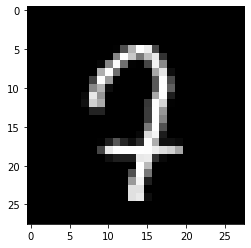

In [13]:
import random

num = random.randint(0, batch_size)
# 随机查看训练集中的一张图片
plot_img(train_data[num])

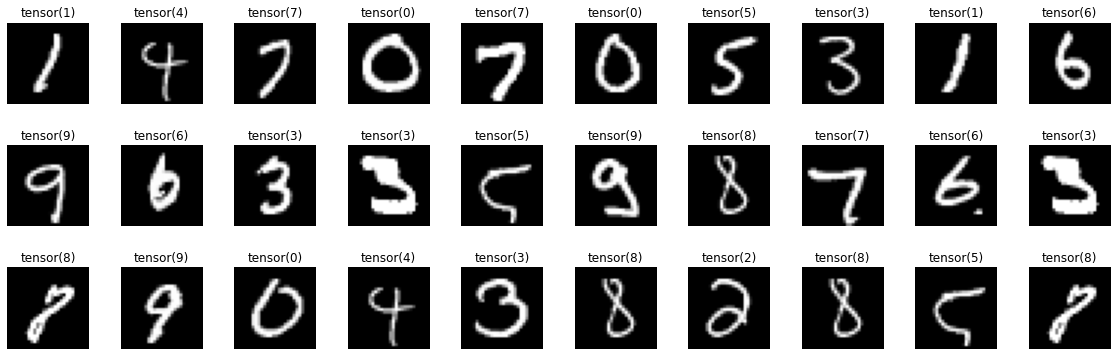

In [14]:
import numpy as np

# 随机查看训练集的30张照片
n_rows = 3
n_cols = 10
plt.figure(figsize=(n_cols * 2, n_rows * 2))
for row in range(n_rows):
    for col in range(n_cols):
        index = np.random.randint(1,batch_size)
        plt.subplot(n_rows, n_cols, n_cols * row + col + 1) 
        plot_img(train_data[index])
        plt.axis('off')
        plt.title(train_label[index], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

thresh = 0.5                     # 神经元的阈值：neuronal-threshold
decay = 0.2                      # 衰减常数：decay-constants
lens = 0.5                       # 近似函数的超参数：hyper-parameters of approximate function
num_classes = 10                 # 分类的种类数目：10个
learning_rate = 1e-3             # 学习率lr
num_epochs = 100                 # 训练次数：最大值100

In [5]:
# ------------------------------------------定义近似激发函数------------------------------------------
class ActFun(torch.autograd.Function):

    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return input.gt(thresh).float()

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        temp = abs(input - thresh) < lens
        return grad_input * temp.float()
    
act_fun = ActFun.apply

In [6]:
# ------------------------------------------膜电位更新函数------------------------------------------
# ops：层      x：输入    mem：膜电位     spike：尖峰电压
def mem_update(ops, x, mem, spike):
    mem = mem * decay * (1. - spike) + ops(x)
    spike = act_fun(mem)
    return mem, spike

In [7]:
# -----------------------------------------衰减学习率lr函数-----------------------------------------
# 【说明】每十进制一个新纪元衰减0.1倍的学习速率。
def lr_scheduler(optimizer, epoch, init_lr=0.1, lr_decay_epoch=50): 
    if epoch % lr_decay_epoch == 0 and epoch > 1:
        for param_group in optimizer.param_groups:
            param_group['lr'] = param_group['lr'] * 0.1
    return optimizer

In [8]:
# 卷积层Conv2d对应的参数(in_planes, out_planes, stride, padding, kernel_size)
cfg_cnn = [(1, 32, 1, 1, 3),
           (32, 32, 1, 1, 3),]
# 卷积核
cfg_kernel = [28, 14, 7]
# fc layer
cfg_fc = [128, num_classes]

class SCNN(nn.Module):
    def __init__(self):
        super(SCNN, self).__init__()
        in_planes, out_planes, stride, padding, kernel_size = cfg_cnn[0]
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding)
        in_planes, out_planes, stride, padding, kernel_size = cfg_cnn[1]
        self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding)

        self.fc1 = nn.Linear(cfg_kernel[-1] * cfg_kernel[-1] * cfg_cnn[-1][1], cfg_fc[0])
        self.fc2 = nn.Linear(cfg_fc[0], cfg_fc[-1])

    def forward(self, input, time_window = 20):
        # -------------------------------1.膜电位mem与尖峰电压spike初始化-------------------------------
        # 【说明】conv1 ---> torch.Size([100, 32, 28, 28])   conv2 ---> torch.Size([100, 32, 14, 14])
        #         fc1   ---> torch.Size([100, 128])          fc2   ---> torch.Size([100, 10])
        c1_mem = c1_spike = torch.zeros(batch_size, cfg_cnn[0][1], cfg_kernel[0], cfg_kernel[0], device=device)   
        c2_mem = c2_spike = torch.zeros(batch_size, cfg_cnn[1][1], cfg_kernel[1], cfg_kernel[1], device=device)
        h1_mem = h1_spike = h1_sumspike = torch.zeros(batch_size, cfg_fc[0], device=device)
        h2_mem = h2_spike = h2_sumspike = torch.zeros(batch_size, cfg_fc[1], device=device)
        
        # -------------------------------2.模拟时间-----------------------------------------------------
        for step in range(time_window): # 时间窗=20次
            # ---------------------------2.1 随机生成数字---> 第一次膜电位更新(conv1)--------------
            x = input > torch.rand(input.size(), device=device) 
#             print('输入：', x.size())
            c1_mem, c1_spike = mem_update(self.conv1, x.float(), c1_mem, c1_spike)
#             print('conv1后x：', x.size())
#             print('conv1后c1_spike：', c1_spike.size())
            # ---------------------------2.2 平均池化层 ---> 第二次膜电位更新(conv2)---------------
            x = F.avg_pool2d(c1_spike, 2)
#             print('avg_pool2d后x：', x.size())
#             print('avg_pool2d后c1_spike：', c1_spike.size())
            c2_mem, c2_spike = mem_update(self.conv2,x, c2_mem,c2_spike)
#             print('conv2后x：', x.size())
#             print('conv2后c2_spike：', c2_spike.size())
            # ---------------------------2.3 平均池化层 ---> 视图展开------------------------------
            x = F.avg_pool2d(c2_spike, 2)
#             print('avg_pool2d后x：', x.size())
#             print('avg_pool2d后c2_spike：', c2_spike.size())
            x = x.view(batch_size, -1)
#             print('扁平化后x：', x.size())
            # ---------------------------2.4 第三次膜电位更新(fc1) ---> 第四次膜电位更新(fc2)------
            h1_mem, h1_spike = mem_update(self.fc1, x, h1_mem, h1_spike)
#             print('fc1后x：', x.size())
#             print('fc1后h1_spike：', h1_spike.size())
            h1_sumspike += h1_spike
            h2_mem, h2_spike = mem_update(self.fc2, h1_spike, h2_mem,h2_spike)
#             print('fc2后x：', x.size())
#             print('fc2后h2_spike：', h2_spike.size())
            h2_sumspike += h2_spike
        
        outputs = h2_sumspike / time_window
#         print('时间窗结束后的outputs：', outputs.size())
        return outputs

In [9]:
from __future__ import print_function
import torchvision
import torchvision.transforms as transforms

# ------------------------------------------相关参数初始化------------------------------------------
best_acc          = 0                  # 最佳准确率acc
start_epoch       = 0                  # 循环epoch起始点
epoch_record      = list([])
train_acc_record  = list([])           # 历史记录：训练acc
train_loss_record = list([])           # 历史记录：训练loss
test_acc_record   = list([])           # 历史记录：测试acc
test_loss_record  = list([])           # 历史记录：测试loss

# ------------------------------------------SCNN网络初始化------------------------------------------
snn = SCNN()
snn.to(device)
criterion = nn.MSELoss()    # 均方误差MSE
optimizer = torch.optim.Adam(snn.parameters(), lr=learning_rate)   # 动量类型的梯度下降法

# ---------------------------------------------模型训练---------------------------------------------
for epoch in range(num_epochs):
    running_loss = 0
    train_loss = 0
    test_loss = 0
    start_time = time.time()  
    
    # ----------------------------------------------1.利用【训练集】进行训练----------------------------------------------
    for i, (images, labels) in enumerate(train_loader):
        # ---------------------------1.1 梯度初始化-------------------------------------
        snn.zero_grad()        
        optimizer.zero_grad()   
        # ---------------------------1.2 将数据转换成模型可以使用的类型-----------------
        images = images.float().to(device)
        labels_ = torch.zeros(batch_size, 10).scatter_(1, labels.view(-1, 1), 1)
        # ---------------------------1.3 将数据载入模型，获取输出-----------------------
        outputs = snn(images)
        # ---------------------------1.4 计算损失---------------------------------------
        loss = criterion(outputs.cpu(), labels_)
        running_loss += loss.item()
        train_loss += loss.item()
        # ---------------------------1.5 反向传播+更新权重------------------------------
        loss.backward()
        optimizer.step()
        # ---------------------------1.6 打印批处理的结果-------------------------------
        # 【说明】因为训练集60000个，每次批处理100个数据；所以每次epoch需要进行600次批处理，而我们需要每进行100次批处理打印一下结果。
        if (i+1)%100 == 0:
             print ('Epoch [%d/%d], Step [%d/%d], Train-Loss: %.5f'
                    %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size,running_loss ))
             running_loss = 0
             print('Time elasped:', time.time()-start_time)   
    
    train_loss_record.append(train_loss)
    train_loss = 0
    # 初始化参数
    correct = 0   # 统计：下面进行测试中正确的个数
    total = 0     # 统计：下面进行测试中样本的总个数
    # 调整学习率
    optimizer = lr_scheduler(optimizer, epoch, learning_rate, 40)    
    
    
    # ----------------------------------------------2.利用【测试集】进行测试----------------------------------------------
    # 100*100=10000张
    # with torch.no_grad()或者@torch.no_grad()中的数据不需要计算梯度，也不会进行反向传播，（torch.no_grad()是新版本pytorch中volatile的替代）
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            # ---------------------------2.1 梯度初始化-------------------------------------
            optimizer.zero_grad()
            # ---------------------------2.2 将数据转换成模型可以使用的类型-----------------
            inputs = inputs.to(device)
            labels_ = torch.zeros(batch_size, 10).scatter_(1, targets.view(-1, 1), 1)
            # ---------------------------2.3 将数据载入模型，获取输出-----------------------
            outputs = snn(inputs)
            # ---------------------------2.4 计算损失---------------------------------------
            loss = criterion(outputs.cpu(), labels_)
            test_loss += loss.item()
            # ---------------------------2.5 统计样本数量及正确个数-------------------------
            _, predicted = outputs.cpu().max(1)
            total += float(targets.size(0))
            correct += float(predicted.eq(targets).sum().item())
            # ---------------------计算第0次batch_idx中0~100测试集的正确率acc---------------
            if batch_idx %100 ==0:
                test_acc = 100. * float(correct) / float(total)
                print(batch_idx, len(test_loader),' Test-Acc: %.5f' % test_acc)
                
    test_acc = 100 * correct / total        
    print('Test Accuracy of the model on the 10000 test images: %.3f' % test_acc,'\n')
    test_acc_record.append(test_acc)                      # 记录每一轮epoch中在测试集中的准确度
    test_loss_record.append(test_loss)
    test_loss = 0
    
    epoch_record.append(epoch)
    history_dic = {
        'epoch_list': epoch_record,
        'train_loss_list': train_loss_record,
        'test_acc_list': test_acc_record,
        'test_loss_list': test_loss_record
    }

Epoch [1/100], Step [100/600], Train-Loss: 5.26889
Time elasped: 9.481263160705566
Epoch [1/100], Step [200/600], Train-Loss: 1.00236
Time elasped: 18.47654390335083
Epoch [1/100], Step [300/600], Train-Loss: 0.67441
Time elasped: 28.184320211410522
Epoch [1/100], Step [400/600], Train-Loss: 0.49643
Time elasped: 37.87829613685608
Epoch [1/100], Step [500/600], Train-Loss: 0.41481
Time elasped: 47.56818175315857
Epoch [1/100], Step [600/600], Train-Loss: 0.35874
Time elasped: 57.26294279098511
0 100  Test-Acc: 100.00000
Test Accuracy of the model on the 10000 test images: 98.270 

Epoch [2/100], Step [100/600], Train-Loss: 0.32666
Time elasped: 8.097130298614502
Epoch [2/100], Step [200/600], Train-Loss: 0.29649
Time elasped: 16.19544744491577
Epoch [2/100], Step [300/600], Train-Loss: 0.24244
Time elasped: 24.293006420135498
Epoch [2/100], Step [400/600], Train-Loss: 0.24231
Time elasped: 32.391507148742676
Epoch [2/100], Step [500/600], Train-Loss: 0.23129
Time elasped: 40.4886889457

Test Accuracy of the model on the 10000 test images: 99.300 

Epoch [15/100], Step [100/600], Train-Loss: 0.02994
Time elasped: 8.152837991714478
Epoch [15/100], Step [200/600], Train-Loss: 0.04638
Time elasped: 16.29568362236023
Epoch [15/100], Step [300/600], Train-Loss: 0.04276
Time elasped: 24.449036121368408
Epoch [15/100], Step [400/600], Train-Loss: 0.03658
Time elasped: 32.59869050979614
Epoch [15/100], Step [500/600], Train-Loss: 0.03953
Time elasped: 40.75349044799805
Epoch [15/100], Step [600/600], Train-Loss: 0.03916
Time elasped: 48.91110301017761
0 100  Test-Acc: 100.00000
Test Accuracy of the model on the 10000 test images: 99.290 

Epoch [16/100], Step [100/600], Train-Loss: 0.02933
Time elasped: 8.143943548202515
Epoch [16/100], Step [200/600], Train-Loss: 0.03431
Time elasped: 16.29722833633423
Epoch [16/100], Step [300/600], Train-Loss: 0.02493
Time elasped: 24.441668272018433
Epoch [16/100], Step [400/600], Train-Loss: 0.04248
Time elasped: 32.590425968170166
Epoch 

Epoch [28/100], Step [600/600], Train-Loss: 0.01528
Time elasped: 48.894694566726685
0 100  Test-Acc: 99.00000
Test Accuracy of the model on the 10000 test images: 99.340 

Epoch [29/100], Step [100/600], Train-Loss: 0.01650
Time elasped: 8.151657581329346
Epoch [29/100], Step [200/600], Train-Loss: 0.01021
Time elasped: 16.29791831970215
Epoch [29/100], Step [300/600], Train-Loss: 0.01772
Time elasped: 24.44687294960022
Epoch [29/100], Step [400/600], Train-Loss: 0.01220
Time elasped: 32.602571964263916
Epoch [29/100], Step [500/600], Train-Loss: 0.01548
Time elasped: 40.81656360626221
Epoch [29/100], Step [600/600], Train-Loss: 0.01909
Time elasped: 49.23245286941528
0 100  Test-Acc: 100.00000
Test Accuracy of the model on the 10000 test images: 99.260 

Epoch [30/100], Step [100/600], Train-Loss: 0.00779
Time elasped: 8.149701118469238
Epoch [30/100], Step [200/600], Train-Loss: 0.00823
Time elasped: 16.30143642425537
Epoch [30/100], Step [300/600], Train-Loss: 0.00922
Time elasped:

Epoch [42/100], Step [500/600], Train-Loss: 0.00432
Time elasped: 40.75273370742798
Epoch [42/100], Step [600/600], Train-Loss: 0.00496
Time elasped: 48.91085958480835
0 100  Test-Acc: 100.00000
Test Accuracy of the model on the 10000 test images: 99.370 

Epoch [43/100], Step [100/600], Train-Loss: 0.00247
Time elasped: 8.152178287506104
Epoch [43/100], Step [200/600], Train-Loss: 0.00656
Time elasped: 16.31040358543396
Epoch [43/100], Step [300/600], Train-Loss: 0.00276
Time elasped: 24.456304788589478
Epoch [43/100], Step [400/600], Train-Loss: 0.00628
Time elasped: 32.608593225479126
Epoch [43/100], Step [500/600], Train-Loss: 0.00676
Time elasped: 40.762818574905396
Epoch [43/100], Step [600/600], Train-Loss: 0.00376
Time elasped: 48.91883683204651
0 100  Test-Acc: 100.00000
Test Accuracy of the model on the 10000 test images: 99.320 

Epoch [44/100], Step [100/600], Train-Loss: 0.00221
Time elasped: 8.161230564117432
Epoch [44/100], Step [200/600], Train-Loss: 0.00556
Time elaspe

Epoch [56/100], Step [400/600], Train-Loss: 0.00456
Time elasped: 32.59820818901062
Epoch [56/100], Step [500/600], Train-Loss: 0.00489
Time elasped: 40.75924277305603
Epoch [56/100], Step [600/600], Train-Loss: 0.00355
Time elasped: 48.908061027526855
0 100  Test-Acc: 100.00000
Test Accuracy of the model on the 10000 test images: 99.320 

Epoch [57/100], Step [100/600], Train-Loss: 0.00263
Time elasped: 8.147547006607056
Epoch [57/100], Step [200/600], Train-Loss: 0.00242
Time elasped: 16.302029132843018
Epoch [57/100], Step [300/600], Train-Loss: 0.00279
Time elasped: 24.459031105041504
Epoch [57/100], Step [400/600], Train-Loss: 0.00742
Time elasped: 32.60969853401184
Epoch [57/100], Step [500/600], Train-Loss: 0.00580
Time elasped: 40.761173248291016
Epoch [57/100], Step [600/600], Train-Loss: 0.00138
Time elasped: 48.91646194458008
0 100  Test-Acc: 100.00000
Test Accuracy of the model on the 10000 test images: 99.350 

Epoch [58/100], Step [100/600], Train-Loss: 0.00424
Time elasp

Epoch [70/100], Step [300/600], Train-Loss: 0.00140
Time elasped: 24.44834303855896
Epoch [70/100], Step [400/600], Train-Loss: 0.00538
Time elasped: 32.6066792011261
Epoch [70/100], Step [500/600], Train-Loss: 0.00160
Time elasped: 40.76443600654602
Epoch [70/100], Step [600/600], Train-Loss: 0.00235
Time elasped: 48.933470010757446
0 100  Test-Acc: 100.00000
Test Accuracy of the model on the 10000 test images: 99.370 

Epoch [71/100], Step [100/600], Train-Loss: 0.00637
Time elasped: 8.153647422790527
Epoch [71/100], Step [200/600], Train-Loss: 0.00252
Time elasped: 16.314650058746338
Epoch [71/100], Step [300/600], Train-Loss: 0.00347
Time elasped: 24.469917058944702
Epoch [71/100], Step [400/600], Train-Loss: 0.00147
Time elasped: 32.633718967437744
Epoch [71/100], Step [500/600], Train-Loss: 0.00461
Time elasped: 40.799402713775635
Epoch [71/100], Step [600/600], Train-Loss: 0.00161
Time elasped: 48.950074672698975
0 100  Test-Acc: 100.00000
Test Accuracy of the model on the 10000

KeyboardInterrupt: 

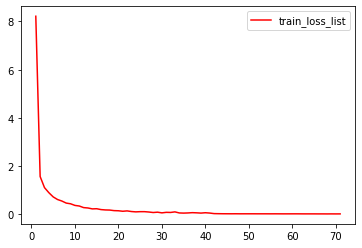

In [10]:
import matplotlib.pyplot as plt

# 可视化：准确率accuracy  acc_record
plt.plot(range(1,len(history_dic['train_loss_list'])+1),history_dic['train_loss_list'],'r',label = 'train_loss_list')
plt.legend()

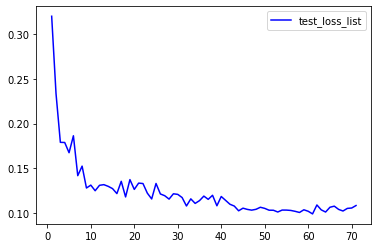

In [11]:
plt.plot(range(1,len(history_dic['test_loss_list'])+1),history_dic['test_loss_list'],'b',label = 'test_loss_list')
plt.legend()

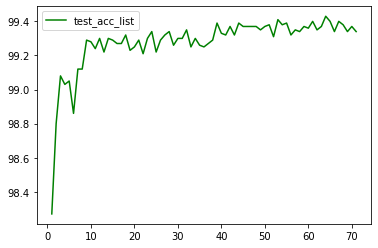

In [12]:
plt.plot(range(1,len(history_dic['test_acc_list'])+1),history_dic['test_acc_list'],'g',label = 'test_acc_list')
plt.legend()